### Without Target Network

Text(0.5, 1.0, 'Epsilon decay by episode')

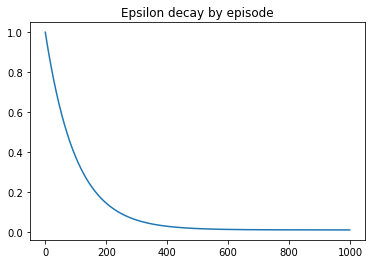

In [1]:
"""This DQN algorithm on MountainCar problem is implemented by Yinyu Jin. 
It is inspired by https://github.com/higgsfield/RL-Adventure"""

import gym
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

env = gym.make("MountainCar-v0")  
env = env.unwrapped

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)
     
    
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 100

epsilon_by_epi = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * episode / epsilon_decay)


plt.plot([epsilon_by_epi(i) for i in range(1000)])
plt.title('Epsilon decay by episode')

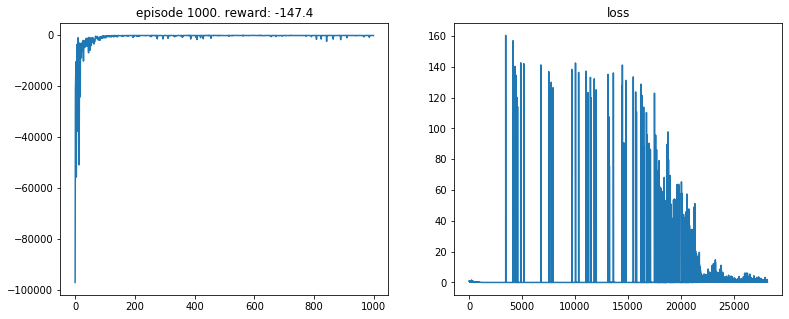

In [4]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    # epsilon-greedy action
    def act(self, state, epsilon):
        if random.random() > epsilon:
            q_value = self.forward(Variable(torch.Tensor(state)))
            action  = torch.argmax(q_value).data.item()
        else:
            action = random.randrange(env.action_space.n)
        return action

model = DQN(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(20000)

def update_policy(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.Tensor(np.float32(state)))
    next_state = Variable(torch.Tensor(np.float32(next_state))).detach()
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.Tensor(reward))
    done       = Variable(torch.Tensor(done))

    q_value      = model(state).gather(dim=1, index = action.unsqueeze(1)).squeeze(1)
    next_q_value = model(next_state).max(1)[0]

    target_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(target_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss


def plot(episode, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

    
num_episodes = 1000
batch_size = 64
gamma      = 0.99

losses = []
all_rewards = []
global_count =0 

for episode in range(1, num_episodes + 1):  
    state = env.reset()
    episode_reward = 0
    
    while True: 
        global_count +=1
        epsilon = epsilon_by_epi(episode)
        action = model.act(state, epsilon)

        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward
        
        if (len(replay_buffer) > batch_size) & (global_count % 30 == 0) :
            loss = update_policy(batch_size)
            losses.append(loss.data.item())  

        if done:
            all_rewards.append(episode_reward)
            
            break
             
    if episode % 10 == 0:
        plot(episode, all_rewards, losses)


### Add Target Network

Text(0.5, 1.0, 'Epsilon decay by episode')

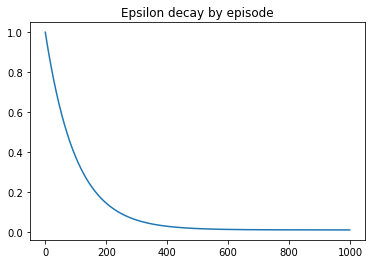

In [5]:
"""This DQN algorithm on MountainCar problem is implemented by Yinyu Jin. """

import gym
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

env = gym.make("MountainCar-v0")  
env = env.unwrapped

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)
     
    
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 100

epsilon_by_epi = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * episode / epsilon_decay)


plt.plot([epsilon_by_epi(i) for i in range(1000)])
plt.title('Epsilon decay by episode')

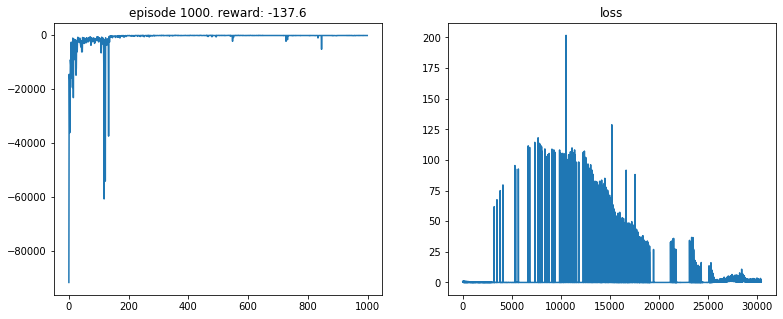

In [6]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, env.action_space.n)
        )
        
        self.learn_policy_counter =0
    
    def forward(self, x):
        return self.layers(x)
    
    # epsilon-greedy action
    def act(self, state, epsilon):
        if random.random() > epsilon:
            q_value = self.forward(Variable(torch.Tensor(state)))
            action  = torch.argmax(q_value).data.item()
        else:
            action = random.randrange(env.action_space.n)
        return action

model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model = DQN(env.observation_space.shape[0], env.action_space.n)

optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(20000)

def update_policy(batch_size):
    if model.learn_policy_counter % replace_target_iter ==0:
        target_model.load_state_dict(model.state_dict())
        
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.Tensor(np.float32(state)))
    next_state = Variable(torch.Tensor(np.float32(next_state))).detach()
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.Tensor(reward))
    done       = Variable(torch.Tensor(done))

    q_value      = model(state).gather(dim=1, index = action.unsqueeze(1)).squeeze(1)
    next_q_value = target_model(next_state).max(1)[0]

    target_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(target_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.learn_policy_counter +=1
    
    return loss


def plot(episode, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

num_episodes = 1000
batch_size = 64
gamma      = 0.99
replace_target_iter = 30


losses = []
all_rewards = []
global_count =0 

for episode in range(1, num_episodes + 1):  
    state = env.reset()
    episode_reward = 0
    
    while True: 
        global_count +=1
        epsilon = epsilon_by_epi(episode)
        action = model.act(state, epsilon)

        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward
        
        if (len(replay_buffer) > batch_size) & (global_count % 30 == 0) :
            loss = update_policy(batch_size)
            losses.append(loss.data.item())  

        if done:
            all_rewards.append(episode_reward)
            
            break
             
    if episode % 1 == 0:
        plot(episode, all_rewards, losses)
